# Лекция 3
## Модели ARIMA и GARCH

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


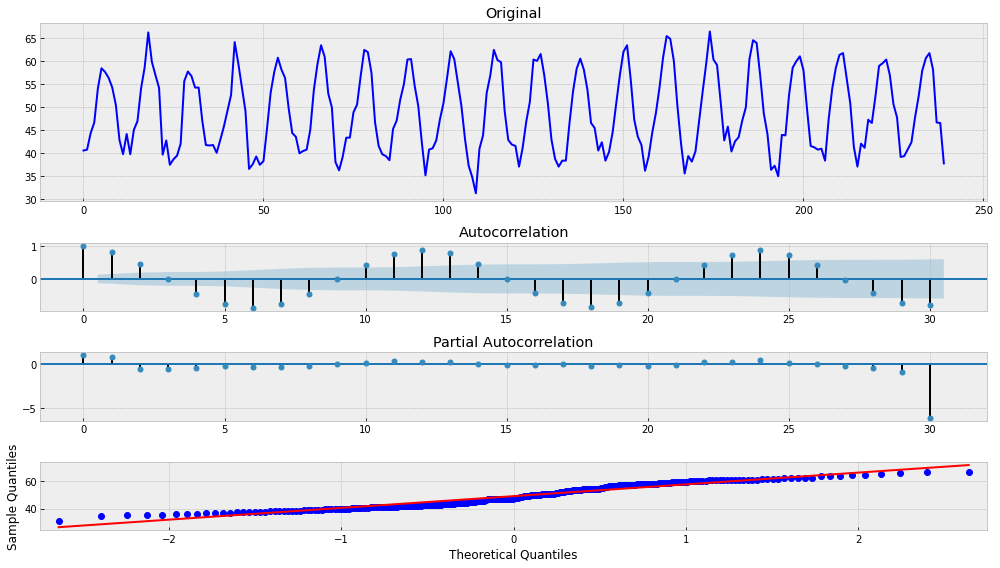

In [30]:
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
tsplot(mean_monthly_temp['Deg'], lags=30)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  

aic: 1151.42209 | order: (2, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -5.645772
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


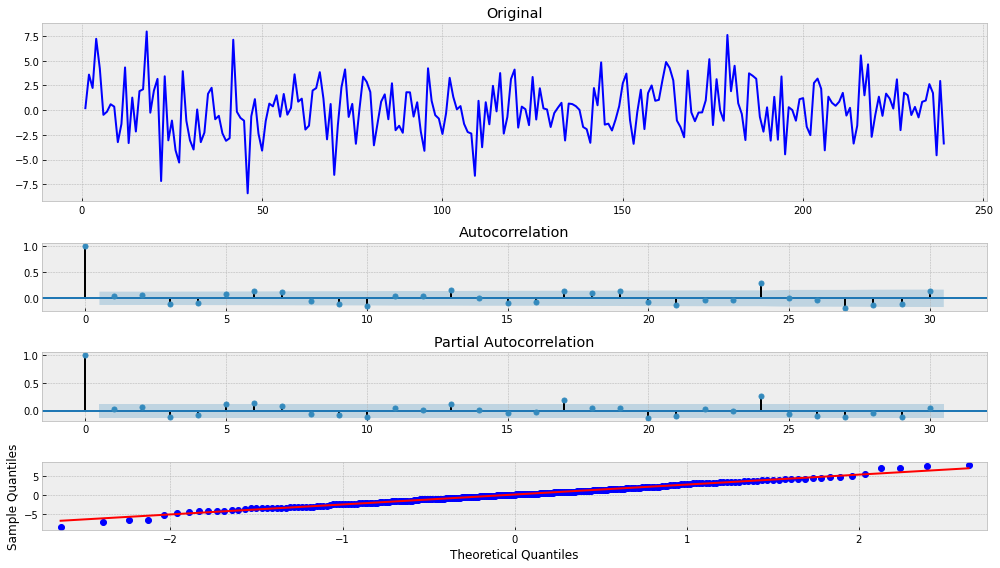

In [12]:
series = mean_monthly_temp['Deg']

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

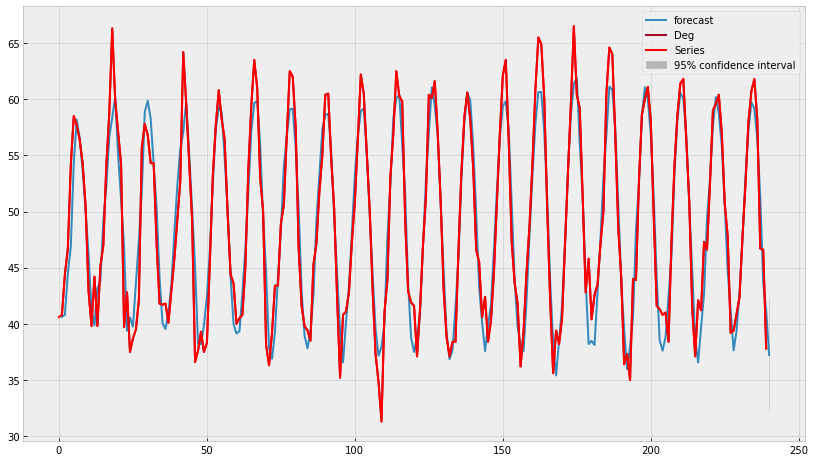

In [62]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series), ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [61]:
print('Средняя ошибка: ', (series - best_mdl.predict(1, len(series))).mean())
# прошу прокомментировать почему вышла такая большая средняя ошибка, на графике не видно таких отклонений

Средняя ошибка:  49.28332272347708


In [42]:

'''дополнительное задание
Предскажем с помоощью обычного ML значения ряда'''


mean_monthly_temp.head()

,Month,Deg,year,mounthno
0,1920-01,40.6,1920,1
1,1920-02,40.8,1920,2
2,1920-03,44.4,1920,3
3,1920-04,46.7,1920,4
4,1920-05,54.1,1920,5


In [43]:
mean_monthly_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     240 non-null    object 
 1   Deg       240 non-null    float64
 2   year      240 non-null    int64  
 3   mounthno  240 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 7.6+ KB


In [47]:
mean_monthly_temp['year'] = mean_monthly_temp['Month'].apply(lambda x: int(x[:4]))
mean_monthly_temp['mounthno'] = mean_monthly_temp['Month'].apply(lambda x: int(x[-2:]))
x = mean_monthly_temp[['year', 'mounthno']]
y = mean_monthly_temp['Deg']

Средняя ошибка:  -0.09466666666666644


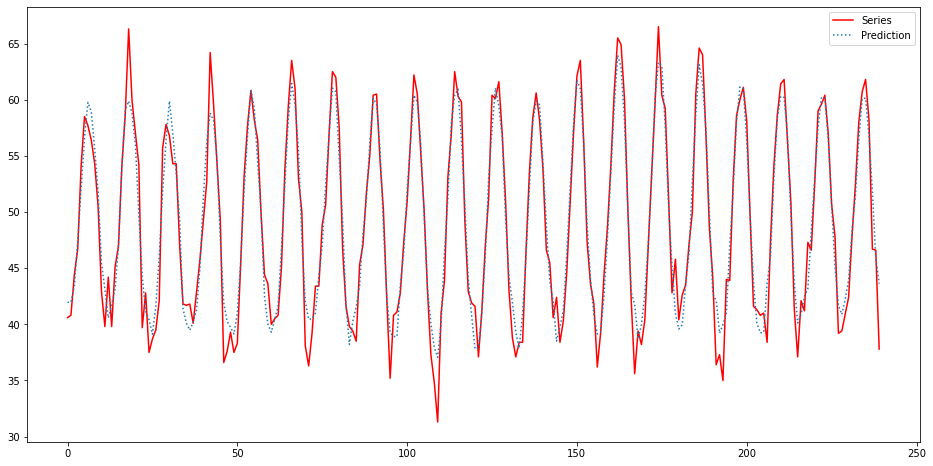

In [67]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights = 'uniform' )

pred = knn.fit(x,y).predict(x)

print('Средняя ошибка: ', (series - pred).mean())

plt.figure(figsize=(16,8))
plt.plot(series, color='red', label='Series')
plt.plot(pred, label='Prediction', linestyle = ':')
plt.legend()
plt.show()   
